### Buffer, dissolve and intersect birds to Utah's major streams

Use re-projected data to buffer and dissolve major streams. Overlay the results with the birds layer and intersect them. The resulting bird layer will be the main layer used in our web map.

Notebook by Zac Stanley for New Maps Plus - MAP674

#### Initialize python libraries

In [2]:
%matplotlib inline

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import mapping
import shapely.speedups # can help speed up processes
import matplotlib.pyplot as plt
import timeit

# change default figsize
plt.rcParams['figure.figsize'] = (15, 12)

#### Import projected datasets

In [4]:
streams = gpd.read_file ("./data/streams_prj.geojson")
birds = gpd.read_file("./data/sw_birds.geojson") # geopandas doesn't like my reprojected bird geojson

In [3]:
# set a variable with parameters
project_params  = '+proj=eqdc +lat_0=39 +lon_0=-96 +lat_1=33 +lat_2=45 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs'

# reproject birds and streams
birds_prj = birds.to_crs(project_params)
streams_prj = streams.to_crs(project_params)

In [4]:
# extract geoseries of Utah
utah = states[states['name']=='Utah']

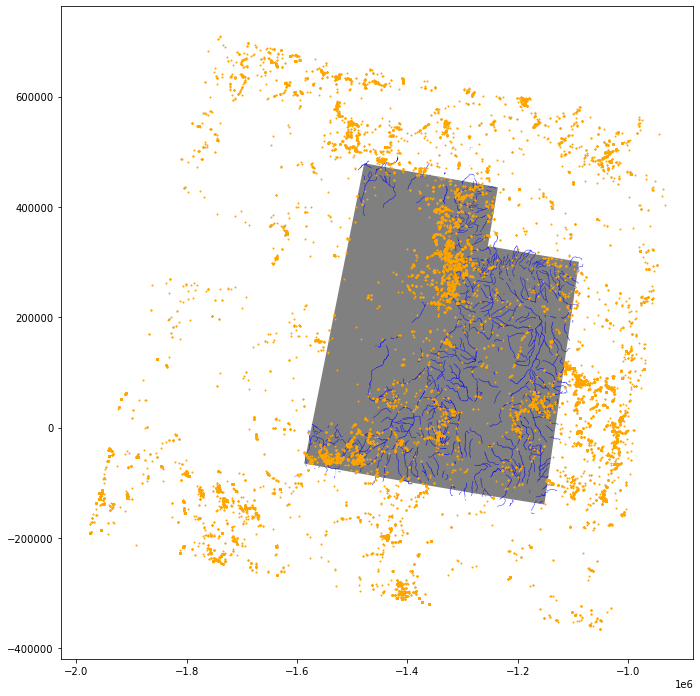

In [5]:
# plot all bird occurences and major streams in the state of Utah 
fig, ax = plt.subplots()

base_color = '#f0f0f0'
border_color = base_color

birds_prj.plot(ax=ax, color='orange', zorder=2, markersize=1);
streams_prj.plot(ax=ax, color='blue', zorder=1, linewidth=.4);
utah.plot(ax=ax, color='grey', zorder=0);


In [6]:
# clip streams to Utah boundary
utah_poly = utah.geometry.unary_union

# create new GeoDataFrame by selecting the streams that intersect with Utah
utah_streams = streams_prj[streams_prj.geometry.intersects(utah_poly)]

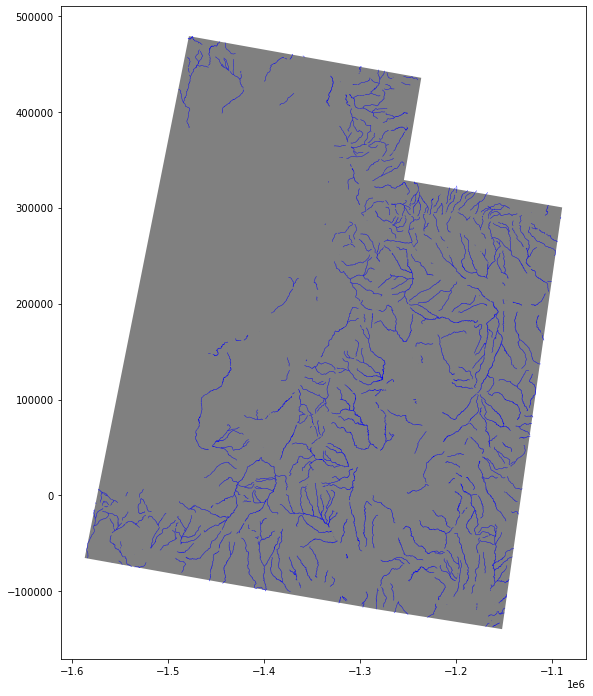

In [7]:
# verify that major streams clipped to the state of Utah 
fig, ax = plt.subplots()

base_color = '#f0f0f0'
border_color = base_color

utah_streams.plot(ax=ax, color='blue', zorder=1, linewidth=.4);
utah.plot(ax=ax, color='grey', zorder=0);

# success

In [8]:
# now let's buffer the streams to 300 feet which is the minimum recommendation for good bird habitat along riparian corridors
# we know the units are in meters so.......300 feet = 91.44 meters
# create a new column in streams and give it the result of our buffer operation
utah_streams['buffer'] = utah_streams.buffer(91.44)

<ipython-input-8-d970a296fe06>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  utah_streams['buffer'] = utah_streams.buffer(91.44)


In [9]:
# make our new buffered column the active geometry
utah_streams = utah_streams.set_geometry('buffer')

# check again what column geometry is referencing
print(utah_streams.geometry.name) # buffer

buffer


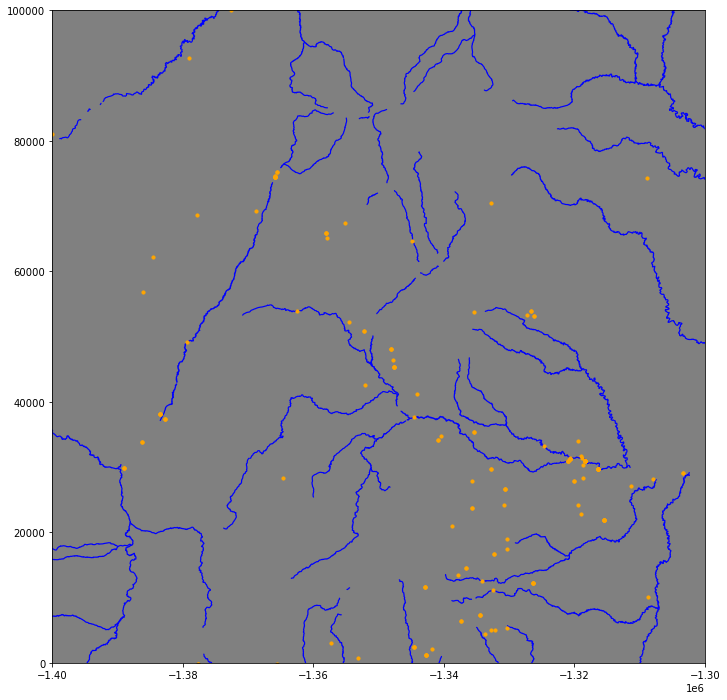

In [18]:
# verify that major streams now have buffer
fig, ax = plt.subplots()

base_color = '#f0f0f0'
border_color = base_color

birds_prj.plot(ax=ax, color='orange', zorder=2, markersize=10);
utah_streams.plot(ax=ax, color='blue', zorder=1);
utah.plot(ax=ax, color='grey', zorder=0);

# modify limits to check that buffers are displayed, confirmed
ax.set(xlim=(-1400000,-1300000), ylim=(0,100000));

In [11]:
# make polygons from stream buffers for clipping mask
utah_streams_buffered = utah_streams.geometry.unary_union

In [12]:
# clip utah_birds to buffered streams
utah_riparian_birds = birds_prj[birds_prj.geometry.intersects(utah_streams_buffered)]

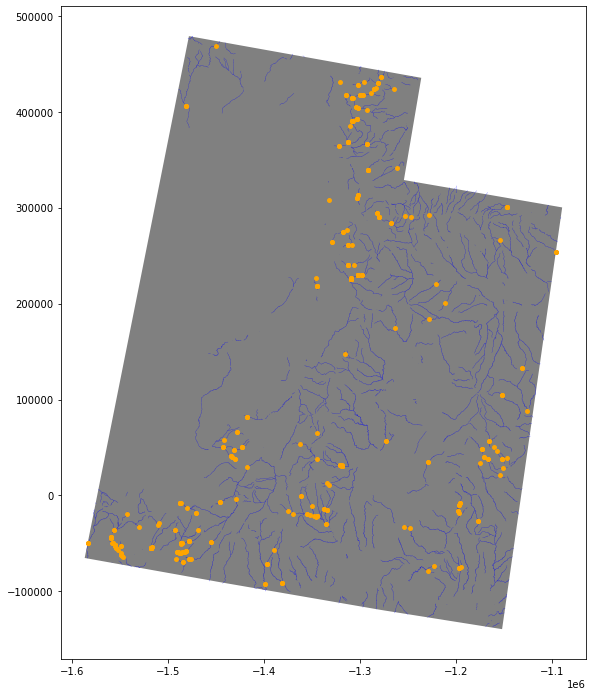

In [13]:
# verify that birds clipped to riparian streams
fig, ax = plt.subplots()

base_color = '#f0f0f0'
border_color = base_color

utah_riparian_birds.plot(ax=ax, color='orange', zorder=2, markersize=15);
utah_streams.plot(ax=ax, color='blue', zorder=1, linewidth=.01);
utah.plot(ax=ax, color='grey', zorder=0);


In [14]:
# look at resulting number of bird occurrences, 582
utah_riparian_birds.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 582 entries, 3 to 27867
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   field_1                 582 non-null    object  
 1   individualCount         582 non-null    object  
 2   occurrenceStatus        582 non-null    object  
 3   year                    582 non-null    object  
 4   month                   582 non-null    object  
 5   day                     582 non-null    object  
 6   stateProvince           582 non-null    object  
 7   county                  582 non-null    object  
 8   locality                582 non-null    object  
 9   decimalLatitude         582 non-null    float64 
 10  decimalLongitude        582 non-null    float64 
 11  scientificName          582 non-null    object  
 12  vernacularName          582 non-null    object  
 13  verbatimScientificName  582 non-null    object  
 14  geometry        

In [15]:
# write resulting clipped bird occurrences to geojson
utah_riparian_birds.to_file("./data/utah_riparian_birds.geojson", driver='GeoJSON')